# Hands-on time

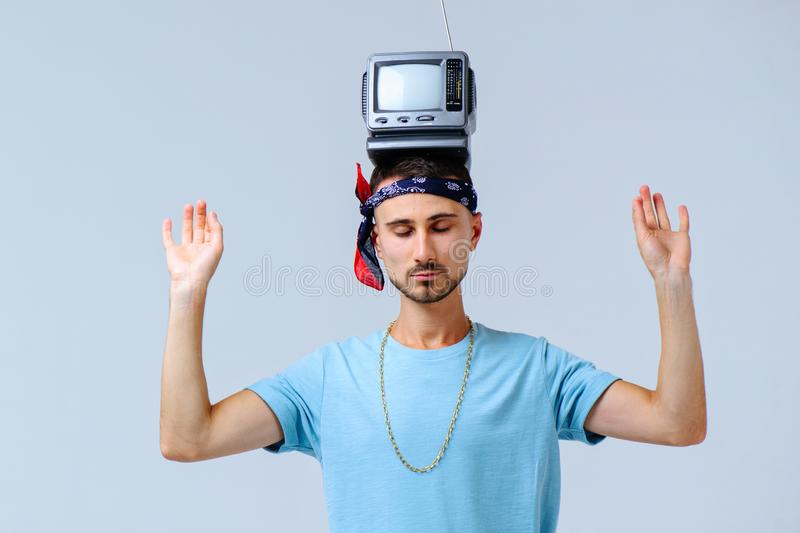

In this lab we'll follow the next steps:
1. Downnload data using Yahoo Finance API
2. Explore and analyze data
3. Learn how to deal with forecasting models - Prophet

In [22]:
# *IMPORT LIBRARIES USED*

!pip install prophet
!pip install yfinance

from prophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

**yfinance**

"Ever since Yahoo! finance decommissioned their historical data API, many programs that relied on it to stop working.

yfinance aimes to solve this problem by offering a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance."

https://pypi.org/project/yfinance/

# 1. Download data

Definition of an analysis starting and ending period

In [23]:
start = pd.to_datetime('2010-01-01')
end = date.today()
#custom_end = pd.to_datetime('2022-05-22')
#end = custom_end

Definition of a list of Ticker: in yfinance you need to specify the rate needed in the following format:  't_currency1t_currency2=X'.

In [24]:
start

Timestamp('2010-01-01 00:00:00')

In [25]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X']

Download the previous tickers only for Close prices

In [98]:
forex_df_list = []

for ticker in tickers_to_download:
  ts = yf.download(ticker, start, end)['Close']
  ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
  forex_df_list.append(ts)

forex_df = pd.concat(forex_df_list, axis=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [99]:
forex_df

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2010-01-01,1.438994,1.613294,1.03390,92.919998,133.710007,1.05120,0.898473
2010-01-04,1.442398,1.611370,1.02910,92.495003,133.389999,1.04100,0.912492
2010-01-05,1.436596,1.599079,1.03370,91.584999,131.529999,1.03950,0.911826
2010-01-06,1.440403,1.602384,1.02760,92.356003,133.013000,1.03190,0.920471
2010-01-07,1.431803,1.593397,1.03360,93.389999,133.748001,1.03400,0.917768
...,...,...,...,...,...,...,...
2024-05-31,1.083541,1.273042,0.90331,156.953003,169.996002,1.36833,0.663030
2024-06-03,1.085305,1.274372,0.90132,157.179993,170.580002,1.36189,0.665690
2024-06-04,1.090739,1.281017,0.89502,156.076004,170.227997,1.36287,0.669008


# 2. Data exploration

### Check missing values and fill if needed

In [100]:
# nan values do exist
forex_df[forex_df.isnull().any(axis=1)]

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2011-04-15,1.443210,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-27,1.309278,1.568209,NaN,77.459999,101.421997,1.0024,1.061582
2012-01-31,1.313957,1.570845,NaN,76.360001,100.330002,1.0024,1.058604
2012-12-04,NaN,1.609787,NaN,82.133003,107.301003,NaN,NaN
2013-10-08,NaN,NaN,NaN,NaN,131.289993,NaN,NaN
2019-05-22,NaN,NaN,NaN,NaN,123.438004,NaN,NaN


Multiple strategies can be used to fill missing values, these depend on the nature of the problem (but be aware of the consequences):

- use median, mode, mean values
- use a statistical method: regression, nearest neighbors
- back/forward fill, **interpolate**
- drop missing data

In [101]:
# fillna fills with given value or method: in this case forward fill
forex_df.fillna(method='ffill', axis=0).loc['2011-04-15']

C:\Users\Julia\AppData\Local\Temp\ipykernel_16388\2608840311.py:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



eurusd_close      1.443210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-15 00:00:00, dtype: float64

In [102]:
forex_df.loc['2011-04-14']

eurusd_close      1.444210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-14 00:00:00, dtype: float64

In [103]:
# interpolate interpolates given a method
forex_df.interpolate(method='linear', axis=0).loc['2011-04-15']

eurusd_close      1.443210
gbpusd_close      1.629145
usdchf_close      0.894250
usdjpy_close     83.465000
eurjpy_close    120.417999
usdcad_close      0.961300
audusd_close      1.053002
Name: 2011-04-15 00:00:00, dtype: float64

In [104]:
forex_df.loc[['2011-04-14', '2011-04-15', '2011-04-18']]

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2011-04-14,1.444210,1.626889,0.8959,83.782997,121.000000,0.9626,1.049803
2011-04-15,1.443210,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-18,1.441296,1.631401,0.8926,83.147003,119.835999,0.9600,1.056201


In [105]:
# let's use interpolation since we are dealing with time series data
forex_df.interpolate(method='linear', axis=0, inplace=True)
# double check on missing data
forex_df[forex_df.isnull().any(axis=1)]

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,


In [106]:
forex_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3763 entries, 2010-01-01 to 2024-06-06
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eurusd_close  3763 non-null   float64
 1   gbpusd_close  3763 non-null   float64
 2   usdchf_close  3763 non-null   float64
 3   usdjpy_close  3763 non-null   float64
 4   eurjpy_close  3763 non-null   float64
 5   usdcad_close  3763 non-null   float64
 6   audusd_close  3763 non-null   float64
dtypes: float64(7)
memory usage: 364.2 KB


In [107]:
forex_df.describe()

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
count,3763.000000,3763.000000,3763.000000,3763.000000,3763.000000,3763.000000,3763.000000
mean,1.194459,1.415017,0.949479,108.512054,127.924484,1.213148,0.807336
std,0.114127,0.152307,0.051317,18.666403,14.335020,0.140542,0.131494
min,0.959619,1.072754,0.722800,75.739998,94.209999,0.943200,0.574290
25%,1.101758,1.279902,0.913895,98.945000,119.519001,1.049125,0.708761
50%,1.164687,1.380110,0.949700,108.902000,128.358002,1.273100,0.759301
75%,1.298802,1.561683,0.984500,115.553001,135.629005,1.326870,0.920810
max,1.484406,1.716090,1.162700,158.223999,170.654007,1.457800,1.103497


### Visualize data

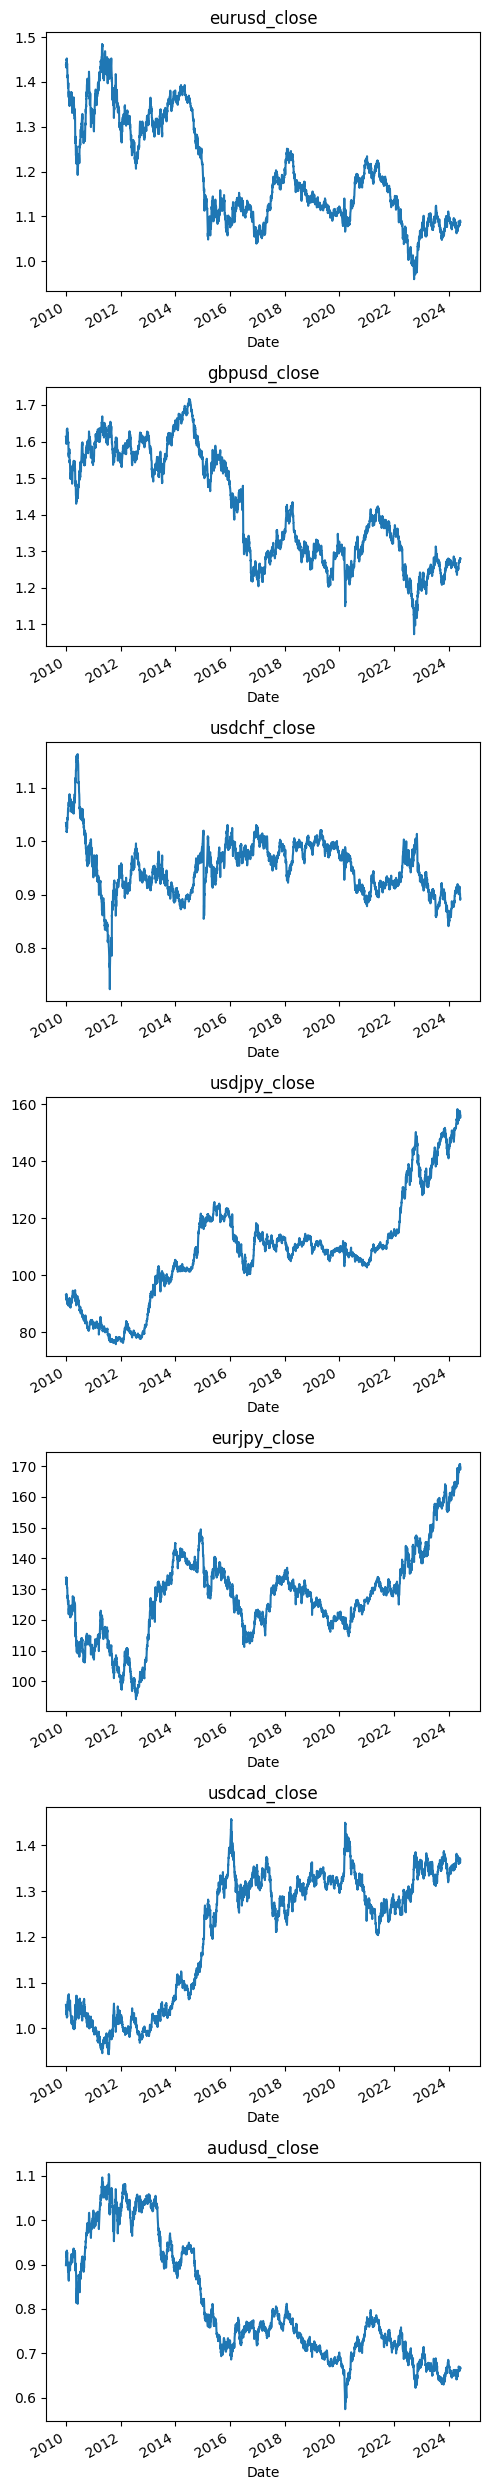

In [108]:
fig, ax = plt.subplots(forex_df.shape[1],1, figsize=(5,25))
for idx, col in enumerate(forex_df):
  forex_df[col].plot(ax=ax[idx])
  ax[idx].set_title(col)
fig.tight_layout()

In [109]:
# Looking for something fancier? go for plotly :-)

for idx, col in enumerate(forex_df):
  fig = px.line(forex_df, y=col)
  fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Scaling the changes using by percentange change, in order to remove differences between pricing, scaling is also vital to perform the Value at Risk calculation and for a statistical analysis.

1. For risk analysis we are more interested in daily changes than in the absolute value of the rate. (e.g. for VaR analysis)

In [ ]:
forex_rate_df = forex_df.pct_change(axis='rows')
forex_rate_df_clean = forex_rate_df.dropna(axis=0)

In [ ]:
# New Dataframe cleaned
forex_rate_df_clean

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2010-01-04,0.002366,-0.001192,-0.004643,-0.004574,-0.002393,-0.009703,0.015604
2010-01-05,-0.004022,-0.007628,0.004470,-0.009838,-0.013944,-0.001441,-0.000729
2010-01-06,0.002650,0.002067,-0.005901,0.008418,0.011275,-0.007311,0.009481
2010-01-07,-0.005971,-0.005609,0.005839,0.011196,0.005526,0.002035,-0.002937
2010-01-08,0.006499,0.005657,-0.009675,-0.007817,-0.001929,-0.004062,0.007956
...,...,...,...,...,...,...,...
2024-05-31,0.003110,0.002554,-0.010397,-0.004156,-0.001292,-0.002457,0.002510
2024-06-03,0.001628,0.001045,-0.002203,0.001446,0.003435,-0.004706,0.004012
2024-06-04,0.005006,0.005214,-0.006990,-0.007024,-0.002064,0.000720,0.004984


Aggregated Returns plot

In [110]:
fig = go.Figure()

for ticker in forex_rate_df_clean.columns:

  # Only thing I figured is - I could do this
  fig.add_scatter(
                  x=forex_rate_df_clean.index,
                  y=forex_rate_df_clean[f'{ticker}'],
                  name=f'{ticker}'
                ) # Not what is desired - need a line

# Show plot
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Standard Deviation of the different rates of returns.

In [111]:
for ticker in forex_rate_df_clean.columns:
  fig = px.histogram(forex_rate_df_clean, x=ticker,
                    marginal="rug", template="plotly_white",
                    hover_data=forex_rate_df_clean.columns,
                    title=f'Distribution of {ticker} the std related to it is {np.round(forex_rate_df_clean[ticker].std(), 3)}')
  fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Correlation analysis between numerical variables.

In [112]:
forex_rate_df_clean.corr()

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
eurusd_close,1.000000,0.606514,-0.621863,-0.297052,0.559105,-0.465043,0.558406
gbpusd_close,0.606514,1.000000,-0.408188,-0.211593,0.312559,-0.461405,0.546074
usdchf_close,-0.621863,-0.408188,1.000000,0.387546,-0.172129,0.283140,-0.376516
usdjpy_close,-0.297052,-0.211593,0.387546,1.000000,0.623687,0.082233,-0.198133
eurjpy_close,0.559105,0.312559,-0.172129,0.623687,1.000000,-0.311689,0.284862
usdcad_close,-0.465043,-0.461405,0.283140,0.082233,-0.311689,1.000000,-0.687495
audusd_close,0.558406,0.546074,-0.376516,-0.198133,0.284862,-0.687495,1.000000


In [113]:
fig = px.scatter_matrix(forex_rate_df_clean,
                        dimensions=forex_rate_df_clean.columns.to_list(),
                        height=1000, width=1000,
                        template='plotly_white'
                        )

fig.update_traces(diagonal_visible=False)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Pearson Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

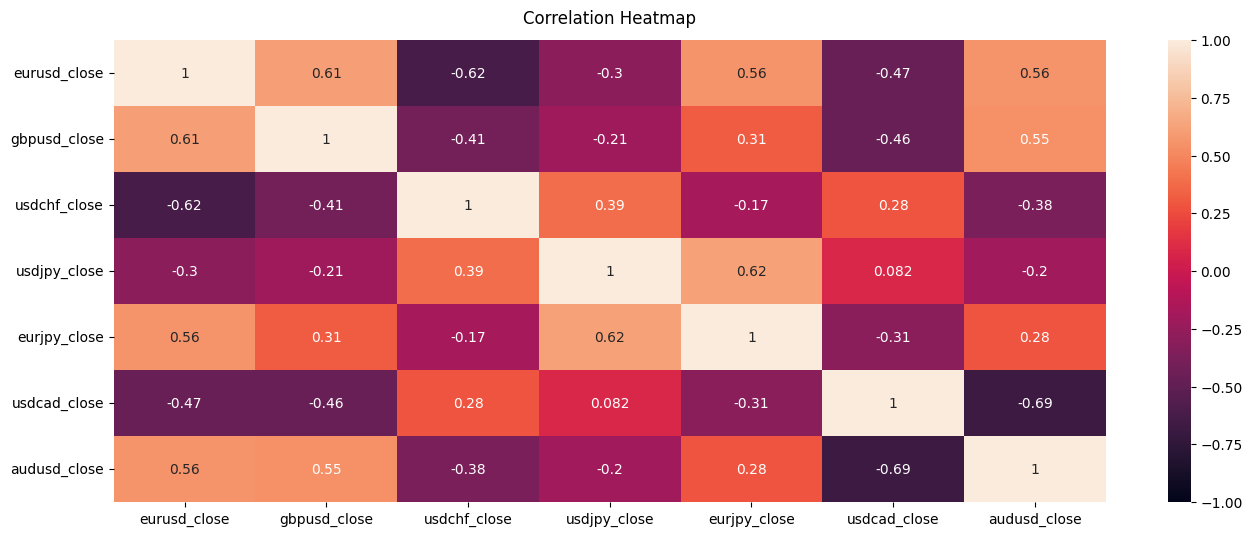

In [114]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(forex_rate_df_clean.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# 3. Forecasting Method - Prophet

Prophet is a library developed by Facebook for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well (Facebook-Prophet website: https://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,daily%20seasonality%2C%20plus%20holiday%20effects.&text=Prophet%20is%20open%20source%20software,download%20on%20CRAN%20and%20PyPI.)

In order to forecast the SINGLE series in the future we need to:
1. ALWAYS add an additional column related to the y variable (in our scenario equal to eurgbp_close) to df['y']
2. ALWAYS Reset the index of the series and rename the column with the date in df['ds']

In [115]:
forex_df

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2010-01-01,1.438994,1.613294,1.03390,92.919998,133.710007,1.05120,0.898473
2010-01-04,1.442398,1.611370,1.02910,92.495003,133.389999,1.04100,0.912492
2010-01-05,1.436596,1.599079,1.03370,91.584999,131.529999,1.03950,0.911826
2010-01-06,1.440403,1.602384,1.02760,92.356003,133.013000,1.03190,0.920471
2010-01-07,1.431803,1.593397,1.03360,93.389999,133.748001,1.03400,0.917768
...,...,...,...,...,...,...,...
2024-05-31,1.083541,1.273042,0.90331,156.953003,169.996002,1.36833,0.663030
2024-06-03,1.085305,1.274372,0.90132,157.179993,170.580002,1.36189,0.665690
2024-06-04,1.090739,1.281017,0.89502,156.076004,170.227997,1.36287,0.669008


In [116]:
# In order to forecast the series we need to: 1.
# 1)
forex_df['ds'] = forex_df.index
forex_df['y'] = forex_df['eurusd_close'].values

forex_df.tail()

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close,ds,y
Date,,,,,,,,,
2024-05-31,1.083541,1.273042,0.90331,156.953003,169.996002,1.36833,0.663030,2024-05-31,1.083541
2024-06-03,1.085305,1.274372,0.90132,157.179993,170.580002,1.36189,0.665690,2024-06-03,1.085305
2024-06-04,1.090739,1.281017,0.89502,156.076004,170.227997,1.36287,0.669008,2024-06-04,1.090739
2024-06-05,1.088187,1.277302,0.88995,155.123993,168.796005,1.36762,0.664620,2024-06-05,1.088187
2024-06-06,1.087453,1.279476,0.89250,155.929001,169.556000,1.36900,0.665779,2024-06-06,1.087453


Create train and test, test used in prophet only for backtesting reason!

In [117]:
# define test and train window
train_window =  ['2010-01-03','2020-10-31']
test_window =  ['2020-11-01','2021-06-10']

In [118]:
# create train and test dataset
train = forex_df[train_window[0]:train_window[1]]
test = forex_df[test_window[0]:test_window[1]]


In [119]:
test

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close,ds,y
Date,,,,,,,,,
2020-11-02,1.164212,1.292674,0.917160,104.580002,121.744003,1.33679,0.700820,2020-11-02,1.164212
2020-11-03,1.164280,1.292390,0.918773,104.724998,121.879997,1.32205,0.705370,2020-11-03,1.164280
2020-11-04,1.176221,1.312164,0.910640,104.545998,122.960999,1.31021,0.719683,2020-11-04,1.176221
2020-11-05,1.173268,1.296680,0.911400,104.438004,122.530998,1.31264,0.718050,2020-11-05,1.173268
2020-11-06,1.181754,1.313940,0.904170,103.602997,122.425003,1.30821,0.726270,2020-11-06,1.181754
...,...,...,...,...,...,...,...,...,...
2021-06-04,1.213301,1.410994,0.903500,110.265999,133.753006,1.21070,0.766577,2021-06-04,1.213301
2021-06-07,1.216841,1.416431,0.899100,109.616997,133.360001,1.20758,0.774400,2021-06-07,1.216841
2021-06-08,1.219363,1.417656,0.897500,109.274002,133.179993,1.20867,0.775630,2021-06-08,1.219363


In [120]:
m = Prophet()
m.fit(train[['ds', 'y']])

15:57:06 - cmdstanpy - INFO - Chain [1] start processing
15:57:07 - cmdstanpy - INFO - Chain [1] done processing


In [121]:
future = m.make_future_dataframe(20, freq='B')

In [122]:
future = m.make_future_dataframe(20, freq='B') # Explain B with https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
foreacast = m.predict(future)

forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)
forecast_results.set_index('ds', inplace=True)

NameError: name 'forecast' is not defined

In [ ]:
forecast_results.plot()

NameError: name 'forecast_results' is not defined

In [ ]:
final_df_results = pd.merge(test[['eurusd_close']], forecast_results[['yhat']], left_index=True, right_index=True, how='inner')

NameError: name 'forecast_results' is not defined

In [ ]:
final_df_results

NameError: name 'final_df_results' is not defined

## Model evaluation and scores

In [ ]:
# Errors
def calc_errors(test, preds):
    percentiles = [5, 25, 50, 75, 95]
    elementwise_mae = np.absolute(np.subtract(preds, test))
    # Mean mae https://en.wikipedia.org/wiki/Mean_absolute_error
    mean_mae = sum(elementwise_mae) / len(test)
    print(f"Mean MAE: {mean_mae:.2f}")
    percent_mae = sum(elementwise_mae) / sum(test)
    print(f"MAE%: {percent_mae * 100:.2f}%")
    # Rmse https://en.wikipedia.org/wiki/Root-mean-square_deviation
    rmse = np.sqrt(np.mean(np.power(np.subtract(preds, test), 2)))
    print(f"RMSE: {rmse:.2f}")
    # Bias https://en.wikipedia.org/wiki/Bias_(statistics)
    bias = np.mean(np.subtract(preds, test))
    print(f"Bias: {bias:.2f}\n")
    # Mae distrib
    distr_mae = []
    for perc in percentiles:
        temp_mae = np.percentile(elementwise_mae, perc)
        distr_mae.append(temp_mae)
        print(f"{perc}th percetile MAE: {temp_mae:.2f}")
    # Plot MAE distribution
    plt.figure(figsize=(8, 8))
    plt.title('MAE distribution')
    plt.xlabel('MAE')
    plt.ylabel('Count')
    # Plot distr
    plt.hist(elementwise_mae, bins=30)
    # plot mean MAE
    plt.axvline(x=mean_mae, label='Mean MAE', c='r', linestyle='-')
    # plot percentiles
    line_types = [':', '-.', '--', '-.', ':']
    for xc, lt, p in zip(distr_mae, line_types, percentiles):
        plt.axvline(x=xc, label='{}th percentile MAE'.format(p), c='r', linestyle=lt)
    plt.legend()
    plt.show()


In [ ]:
final_df_results.describe()

NameError: name 'final_df_results' is not defined

In [ ]:
# Analyze the forecast error
calc_errors(final_df_results['eurusd_close'].values, final_df_results['yhat'].values)


NameError: name 'final_df_results' is not defined

In [123]:
# explore the components of the fitted model
fig = m.plot_components(forecast)

NameError: name 'forecast' is not defined

In [124]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

NameError: name 'final_df_results' is not defined

### Short long story: work hard for nothing

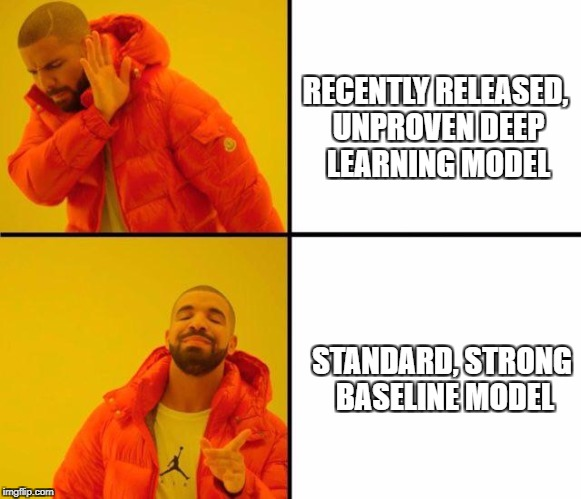

Let's have a look if "stupid" model is able to make better prediction than our method. We are going to shift the value of EURUSD change and use the value of 7 days ago to predict the value of EURUSD for tomorrow

In [125]:
final_df_results


NameError: name 'final_df_results' is not defined

In [126]:
final_df_results['yhat_baselinemodel'] = final_df_results['eurusd_close'].rolling(7).mean()

NameError: name 'final_df_results' is not defined

In [127]:
# Analyze the forecast error
calc_errors(final_df_results.dropna()['yhat_baselinemodel'].values, final_df_results.dropna()['eurusd_close'].values)


NameError: name 'final_df_results' is not defined

## Improve forecasting perfomances : hyperparameter tuning and extra regressors

### Load useful data

What's the influence of external forces on FOREX?

We have dowload different timeseries that could have influenced the FOREX. It's clear that the use of these regressors to improve the forecasting performances increases the complexity of the model.

i.e. Let's say that we would like to forecast FOREX in the horizon May 2021 - Jan 2022. The values of extra regressor should be known, which means that other ML models should be use to forecast for example US GDP

Here we studied the effect of GDP, inflation and consumer price index on FOREX. Raw data where download from https://fred.stlouisfed.org/

### What about COVID-19?

Is the global vaccination race the new force in FX markets? – Special Report

https://www.xm.com/is-the-global-vaccination-race-the-new-force-in-fx-markets-special-report-135646

2020 and 2021 have been affected by COVID-19 pandemic. We all know the effect of the pandemic on daily life and economics. Starting from the first days of 2021, vaccinations and growth perspective have influenced a slow restart of "normal" life and therefore of economy.

Here we explore the effect of covid and vaccinations on FOREX. Data were download from https://github.com/owid/covid-19-data

In [64]:
# To load data from your google drive

from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

Change the directory below using the one you have loaded the data in

In [65]:
%cd /content/drive/MyDrive/2024_course

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/2024_course'
d:\Studies\Materials\Second-cycle\I year\III trimester\Ammagamma-Lab\ammagamma-lab\part-1


d:\Studies\Materials\Second-cycle\I year\III trimester\Ammagamma-Lab\ammagamma-lab\ag-lab\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning:

This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.



In [66]:
df_covid = pd.read_csv('./owid-covid-data.csv', parse_dates=['date'], index_col='date')
extra_df = pd.read_csv('./extra_regressors.csv', parse_dates=['DATE'])

In [67]:
extra_df.isnull().sum()/extra_df.shape[0]

DATE        0.000000
CPIAUCSL    0.000000
GDP         0.000000
T10YIE      0.932754
dtype: float64

In [68]:
extra_df.set_index('DATE',inplace=True)
# remap column name
map_dict = {'CPIAUCSL':'consumer_price_index', 'GDP':'GDP_US', 'T10YIE':'inflation'}
extra_df = extra_df.rename(columns=map_dict)
# group data for each continent and sum the number of new cases
df_covid_g = df_covid.groupby(['continent','date']).agg({'new_cases':'sum'})


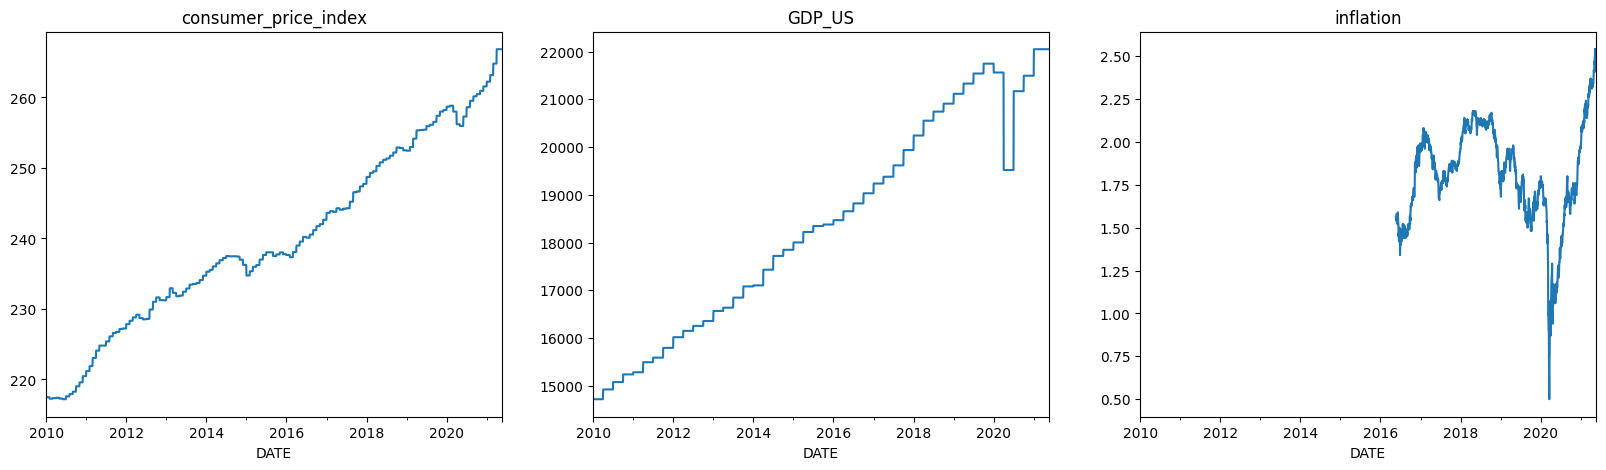

In [69]:
# plot timeseries
fig, ax = plt.subplots(1,3, figsize=(20,5))
for idx, col in enumerate(extra_df):
  extra_df[col].loc[forex_df.index[0]:forex_df.index[-1]].plot(ax=ax[idx])
  ax[idx].set_title(col)

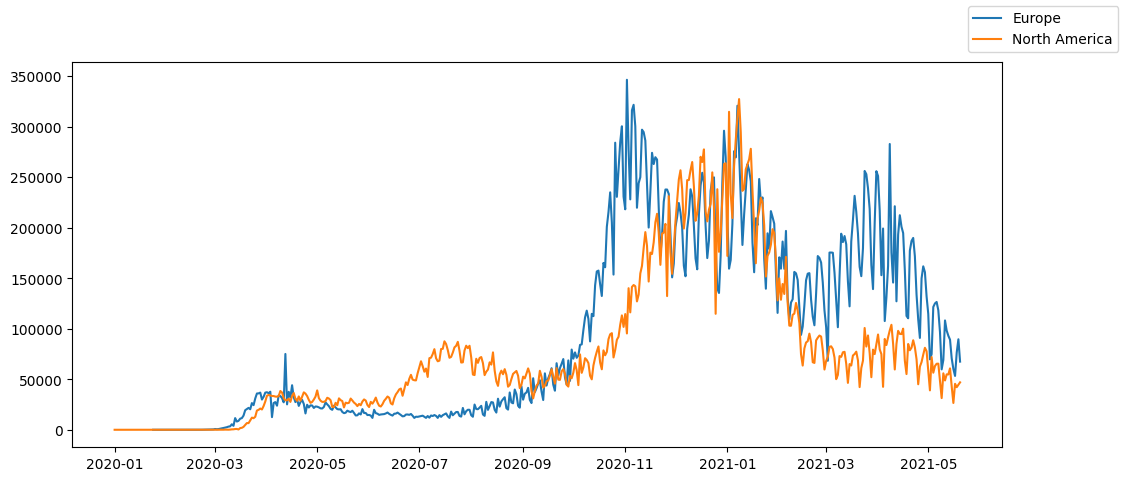

In [70]:
# compare Europe and North America time series
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_covid_g.loc['Europe'], label='Europe')
ax.plot(df_covid_g.loc['North America'], label='North America')
fig.legend()

### Timeseries correlation

# TASK: merge EURUSD data with external regressors and evaluate correlation.
Since you cannot use unavailable data for your prediction, shift all external regressor by two weeks so that you are sure you have all data available

## Solution

In [128]:
EURUSD_data = forex_df[['ds','y']].copy()

In [129]:
EURUSD_data

,ds,y
Date,,
2010-01-01,2010-01-01,1.438994
2010-01-04,2010-01-04,1.442398
2010-01-05,2010-01-05,1.436596
2010-01-06,2010-01-06,1.440403
2010-01-07,2010-01-07,1.431803
...,...,...
2024-05-31,2024-05-31,1.083541
2024-06-03,2024-06-03,1.085305
2024-06-04,2024-06-04,1.090739


In [130]:
EURUSD_data['two_weeks_before'] = EURUSD_data['ds'] - pd.to_timedelta(2,  unit='W')

In [131]:
extra_df

,consumer_price_index,GDP_US,inflation
DATE,,,
1947-01-01,21.480,243.164,NaN
1947-01-02,21.480,243.164,NaN
1947-01-03,21.480,243.164,NaN
1947-01-04,21.480,243.164,NaN
1947-01-05,21.480,243.164,NaN
...,...,...,...
2021-05-16,266.832,22048.894,2.51
2021-05-17,266.832,22048.894,2.54
2021-05-18,266.832,22048.894,2.52


In [132]:
df_covid_g

new_cases
continent     date                 
Africa        2020-02-07        0.0
              2020-02-08        0.0
              2020-02-09        0.0
              2020-02-10        0.0
              2020-02-11        0.0
...                             ...
South America 2021-05-16    98636.0
              2021-05-17    86124.0
              2021-05-18   140027.0
              2021-05-19   162198.0
              2021-05-20   155760.0

[2948 rows x 1 columns]

In [133]:
df_covid_g.loc['Europe'].rename(columns={'new_cases':'covid_EU'})

,covid_EU
date,
2020-01-24,2.0
2020-01-25,1.0
2020-01-26,0.0
2020-01-27,1.0
2020-01-28,4.0
...,...
2021-05-16,60183.0
2021-05-17,53323.0
2021-05-18,76497.0


In [134]:
EURUSD_data_reg = EURUSD_data.merge(extra_df, left_on='two_weeks_before', right_index=True, how='left')

EURUSD_data_reg = EURUSD_data_reg.merge(df_covid_g.loc['North America'].rename(columns={'new_cases':'covid_US'}), left_on='two_weeks_before', right_index=True, how='left')
EURUSD_data_reg = EURUSD_data_reg.merge(df_covid_g.loc['Europe'].rename(columns={'new_cases':'covid_EU'}), left_on='two_weeks_before', right_index=True, how='left')
EURUSD_data_reg['covid_US'] = EURUSD_data_reg['covid_US'].fillna(0)
EURUSD_data_reg['covid_EU'] = EURUSD_data_reg['covid_EU'].fillna(0)

In [135]:
EURUSD_data_reg

,ds,y,two_weeks_before,consumer_price_index,GDP_US,inflation,covid_US,covid_EU
Date,,,,,,,,
2010-01-01,2010-01-01,1.438994,2009-12-18,217.347,14628.021,NaN,0.0,0.0
2010-01-04,2010-01-04,1.442398,2009-12-21,217.347,14628.021,NaN,0.0,0.0
2010-01-05,2010-01-05,1.436596,2009-12-22,217.347,14628.021,NaN,0.0,0.0
2010-01-06,2010-01-06,1.440403,2009-12-23,217.347,14628.021,NaN,0.0,0.0
2010-01-07,2010-01-07,1.431803,2009-12-24,217.347,14628.021,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-05-31,2024-05-31,1.083541,2024-05-17,NaN,NaN,NaN,0.0,0.0
2024-06-03,2024-06-03,1.085305,2024-05-20,NaN,NaN,NaN,0.0,0.0
2024-06-04,2024-06-04,1.090739,2024-05-21,NaN,NaN,NaN,0.0,0.0


In [136]:
forex_df_reg = EURUSD_data_reg.copy()

In [137]:
forex_df_reg.columns

Index(['ds', 'y', 'two_weeks_before', 'consumer_price_index', 'GDP_US',
       'inflation', 'covid_US', 'covid_EU'],
      dtype='object')

<Axes: >

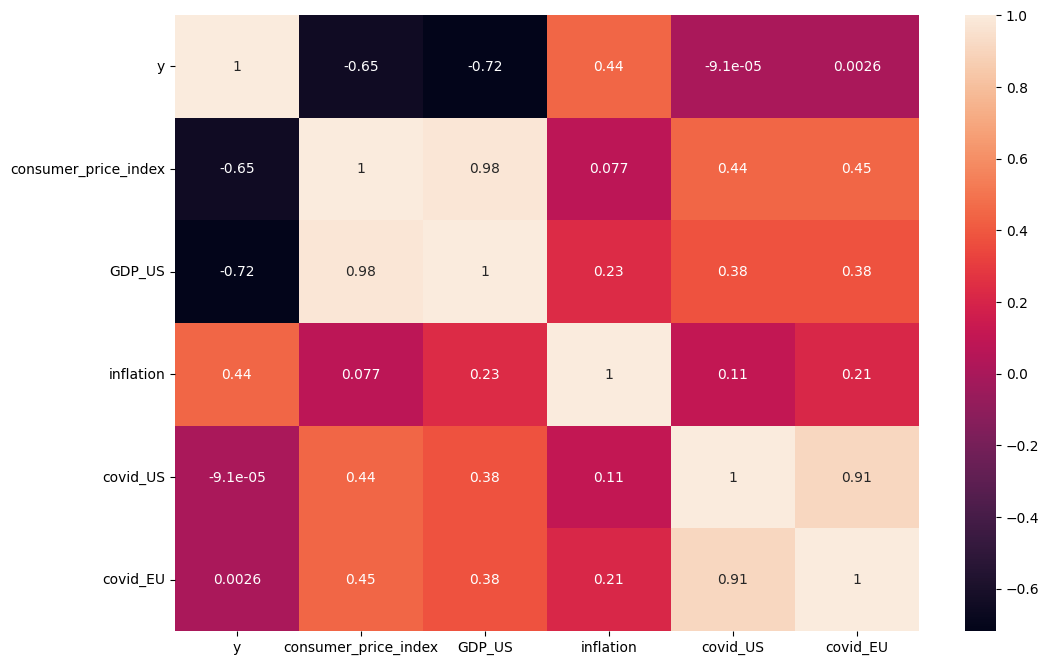

In [138]:
# explore correlation
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(forex_df_reg[['y', 'consumer_price_index', 'GDP_US',
       'inflation', 'covid_US', 'covid_EU']].corr(), annot=True, ax=ax)

### Forecasting using extra regressors with Prophet

# TASK: create a new model that exploits external regressors.
* Use function addregressor() to add your regressors and train a new model.
* Explore the usage of from prophet.diagnostics import cross_validation function.
* Create a cross validation experiment with cutoffs of the last 100 steps.
* test on the test dataset as before and evaluate performance metrics

In [139]:
forex_df_reg_1 = forex_df_reg[['ds', 'y', 'consumer_price_index', 'GDP_US', 'inflation', 'covid_US', 'covid_EU']].reset_index().iloc[:, 1:].dropna()
forex_df_reg_1

,ds,y,consumer_price_index,GDP_US,inflation,covid_US,covid_EU
1675,2016-06-03,1.115200,239.557,18656.207,1.56,0.0,0.0
1676,2016-06-06,1.135100,239.557,18656.207,1.54,0.0,0.0
1677,2016-06-07,1.136402,239.557,18656.207,1.55,0.0,0.0
1678,2016-06-08,1.135783,239.557,18656.207,1.58,0.0,0.0
1679,2016-06-09,1.140706,239.557,18656.207,1.58,0.0,0.0
...,...,...,...,...,...,...,...
2973,2021-05-28,1.219319,266.832,22048.894,2.51,60795.0,89157.0
2974,2021-05-31,1.219007,266.832,22048.894,2.54,45487.0,53323.0
2975,2021-06-01,1.223287,266.832,22048.894,2.52,42170.0,76497.0
2976,2021-06-02,1.221777,266.832,22048.894,2.48,44661.0,89586.0


In [83]:
m = Prophet()
m.add_regressor('consumer_price_index')
m.add_regressor('GDP_US')
m.add_regressor('inflation')
m.add_regressor('covid_US')
m.add_regressor('covid_EU')
m.fit(forex_df_reg_1)

15:51:25 - cmdstanpy - INFO - Chain [1] start processing
15:51:26 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
forex_df_reg_1.shape

(1303, 7)

In [85]:
cut_offs = pd.DataFrame(forex_df_reg_1[-114:-14]['ds'])

date_strings = [timestamp.strftime('%Y-%m-%d') for timestamp in cut_offs['ds'].to_list()]
date_strings

['2020-12-28',
 '2020-12-29',
 '2020-12-30',
 '2020-12-31',
 '2021-01-01',
 '2021-01-04',
 '2021-01-05',
 '2021-01-06',
 '2021-01-07',
 '2021-01-08',
 '2021-01-11',
 '2021-01-12',
 '2021-01-13',
 '2021-01-14',
 '2021-01-15',
 '2021-01-18',
 '2021-01-19',
 '2021-01-20',
 '2021-01-21',
 '2021-01-22',
 '2021-01-25',
 '2021-01-26',
 '2021-01-27',
 '2021-01-28',
 '2021-01-29',
 '2021-02-01',
 '2021-02-02',
 '2021-02-03',
 '2021-02-04',
 '2021-02-05',
 '2021-02-08',
 '2021-02-09',
 '2021-02-10',
 '2021-02-11',
 '2021-02-12',
 '2021-02-15',
 '2021-02-16',
 '2021-02-17',
 '2021-02-18',
 '2021-02-19',
 '2021-02-22',
 '2021-02-23',
 '2021-02-24',
 '2021-02-25',
 '2021-02-26',
 '2021-03-01',
 '2021-03-02',
 '2021-03-03',
 '2021-03-04',
 '2021-03-05',
 '2021-03-08',
 '2021-03-09',
 '2021-03-10',
 '2021-03-11',
 '2021-03-12',
 '2021-03-15',
 '2021-03-16',
 '2021-03-17',
 '2021-03-18',
 '2021-03-19',
 '2021-03-22',
 '2021-03-23',
 '2021-03-24',
 '2021-03-25',
 '2021-03-26',
 '2021-03-29',
 '2021-03-

In [86]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, cutoffs=pd.to_datetime(date_strings), period='1 days', horizon='14 days')
df_cv

  0%|          | 0/100 [00:00<?, ?it/s]15:51:27 - cmdstanpy - INFO - Chain [1] start processing
15:51:28 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/100 [00:00<01:02,  1.59it/s]15:51:28 - cmdstanpy - INFO - Chain [1] start processing
15:51:29 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 2/100 [00:01<01:15,  1.30it/s]15:51:29 - cmdstanpy - INFO - Chain [1] start processing
15:51:30 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 3/100 [00:02<01:17,  1.25it/s]15:51:30 - cmdstanpy - INFO - Chain [1] start processing
15:51:30 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 4/100 [00:03<01:16,  1.25it/s]15:51:31 - cmdstanpy - INFO - Chain [1] start processing
15:51:31 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 5/100 [00:03<01:16,  1.25it/s]15:51:31 - cmdstanpy - INFO - Chain [1] start processing
15:51:32 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 6/100 [00:04<01:16,  1.23it/s]


KeyboardInterrupt: 

In [87]:
df_cv['days_difference'] = df_cv['ds'] - df_cv['cutoff']
df_cv['days_difference'] = df_cv['days_difference'].astype(str).str.replace(' days', '').astype(int)
# or df_cv['days_difference'].dt.days

df_cv_selected = df_cv[df_cv['days_difference'] == 14][['ds', 'yhat', 'y', 'cutoff']]
df_cv_selected_1 = df_cv_selected.rename(columns={'y': 'y_ds'}).merge(forex_df_reg_1[['ds', 'y']], how='left', left_on='cutoff', right_on='ds').drop("ds_y", axis= 1).rename(columns={'ds_x': 'ds', 'y': 'y_cutoff'})
df_cv_selected_1['delta_y_cutoff_to_ds'] = df_cv_selected_1['y_ds'] - df_cv_selected_1['y_cutoff']
df_cv_selected_1['delta_y_cutoff_to_yhat'] = df_cv_selected_1['yhat'] - df_cv_selected_1['y_cutoff']

df_cv_selected_1['delta_y_cutoff_to_ds'] = df_cv_selected_1['delta_y_cutoff_to_ds'].apply(lambda x: 1 if x>0 else 0)
df_cv_selected_1['delta_y_cutoff_to_yhat'] = df_cv_selected_1['delta_y_cutoff_to_yhat'].apply(lambda x: 1 if x>0 else 0)
df_cv_selected_1

NameError: name 'df_cv' is not defined

In [88]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

acc = accuracy_score(df_cv_selected_1['delta_y_cutoff_to_ds'], df_cv_selected_1['delta_y_cutoff_to_yhat'])
print('Accuracy: ', acc)

conf_mat = confusion_matrix(df_cv_selected_1['delta_y_cutoff_to_ds'], df_cv_selected_1['delta_y_cutoff_to_yhat'])
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()

NameError: name 'df_cv_selected_1' is not defined

# TASK: Can you think at other useful external regressors?
Find new data, add them and test their efficacy

In [147]:
# Use sentiment as an additional regressor
new_data = pd.read_csv('D:/Studies/Materials/Second-cycle/I year/III trimester/Ammagamma-Lab/ammagamma-lab/part-2/new_data.csv')
new_data['date'] = pd.to_datetime(new_data['date'])
new_data

,date,sentiment
0,2021-03-31,neutral
1,2021-03-25,neutral
2,2021-03-19,neutral
3,2021-03-12,neutral
4,2021-03-10,neutral
...,...,...
214,2021-04-22,neutral
215,2021-04-15,neutral
216,2021-04-12,neutral
217,2021-04-06,neutral


In [161]:
forex_df_reg_1.to_csv('D:/Studies/Materials/Second-cycle/I year/III trimester/Ammagamma-Lab/ammagamma-lab/part-2/forex_data.csv')

In [148]:
forex_df_reg_2 = forex_df_reg_1.merge(new_data, how='left', left_on='ds', right_on='date')
forex_df_reg_2

,ds,y,consumer_price_index,GDP_US,inflation,covid_US,covid_EU,date,sentiment
0,2016-06-03,1.115200,239.557,18656.207,1.56,0.0,0.0,NaT,NaN
1,2016-06-06,1.135100,239.557,18656.207,1.54,0.0,0.0,NaT,NaN
2,2016-06-07,1.136402,239.557,18656.207,1.55,0.0,0.0,NaT,NaN
3,2016-06-08,1.135783,239.557,18656.207,1.58,0.0,0.0,NaT,NaN
4,2016-06-09,1.140706,239.557,18656.207,1.58,0.0,0.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...
1300,2021-05-28,1.219319,266.832,22048.894,2.51,60795.0,89157.0,NaT,NaN
1301,2021-05-31,1.219007,266.832,22048.894,2.54,45487.0,53323.0,2021-05-31,negative
1302,2021-06-01,1.223287,266.832,22048.894,2.52,42170.0,76497.0,NaT,NaN
1303,2021-06-02,1.221777,266.832,22048.894,2.48,44661.0,89586.0,NaT,NaN


In [155]:
# Remove rows where there are missing values in 'sentiment'
forex_df_reg_3 = forex_df_reg_2.drop('date', axis=1)
forex_df_reg_3['sentiment'] = forex_df_reg_3['sentiment'].apply(lambda x: 0 if x == 'negative' else (1 if x == 'neutral' else 2))
forex_df_reg_3

,ds,y,consumer_price_index,GDP_US,inflation,covid_US,covid_EU,sentiment
0,2016-06-03,1.115200,239.557,18656.207,1.56,0.0,0.0,2
1,2016-06-06,1.135100,239.557,18656.207,1.54,0.0,0.0,2
2,2016-06-07,1.136402,239.557,18656.207,1.55,0.0,0.0,2
3,2016-06-08,1.135783,239.557,18656.207,1.58,0.0,0.0,2
4,2016-06-09,1.140706,239.557,18656.207,1.58,0.0,0.0,2
...,...,...,...,...,...,...,...,...
1300,2021-05-28,1.219319,266.832,22048.894,2.51,60795.0,89157.0,2
1301,2021-05-31,1.219007,266.832,22048.894,2.54,45487.0,53323.0,0
1302,2021-06-01,1.223287,266.832,22048.894,2.52,42170.0,76497.0,2
1303,2021-06-02,1.221777,266.832,22048.894,2.48,44661.0,89586.0,2


In [156]:
# Fit a new model
m_1 = Prophet()
m_1.add_regressor('consumer_price_index')
m_1.add_regressor('GDP_US')
m_1.add_regressor('inflation')
m_1.add_regressor('covid_US')
m_1.add_regressor('covid_EU')
m_1.add_regressor('sentiment')
m_1.fit(forex_df_reg_3)

16:07:01 - cmdstanpy - INFO - Chain [1] start processing
16:07:01 - cmdstanpy - INFO - Chain [1] done processing


In [157]:
from prophet.diagnostics import cross_validation

df_cv_1 = cross_validation(m_1, cutoffs=pd.to_datetime(date_strings), period='1 days', horizon='14 days')
df_cv_1

  0%|          | 0/100 [00:00<?, ?it/s]16:10:22 - cmdstanpy - INFO - Chain [1] start processing
16:10:23 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/100 [00:00<01:27,  1.13it/s]16:10:23 - cmdstanpy - INFO - Chain [1] start processing
16:10:23 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 2/100 [00:01<01:20,  1.22it/s]16:10:24 - cmdstanpy - INFO - Chain [1] start processing
16:10:24 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 3/100 [00:02<01:14,  1.30it/s]16:10:24 - cmdstanpy - INFO - Chain [1] start processing
16:10:25 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 4/100 [00:03<01:14,  1.28it/s]16:10:25 - cmdstanpy - INFO - Chain [1] start processing
16:10:26 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 5/100 [00:03<01:15,  1.25it/s]16:10:26 - cmdstanpy - INFO - Chain [1] start processing
16:10:27 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 6/100 [00:04<01:15,  1.25it/s]1

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-12-29,1.223515,1.212341,1.235354,1.222345,2020-12-28
1,2020-12-30,1.230348,1.219107,1.240938,1.225295,2020-12-28
2,2020-12-31,1.230894,1.219855,1.241608,1.229990,2020-12-28
3,2021-01-01,1.234463,1.222442,1.245776,1.218027,2020-12-28
4,2021-01-04,1.225037,1.213111,1.235670,1.225070,2020-12-28
...,...,...,...,...,...,...
1005,2021-05-24,1.209910,1.197948,1.221749,1.218324,2021-05-14
1006,2021-05-25,1.207839,1.195556,1.219552,1.221464,2021-05-14
1007,2021-05-26,1.210583,1.199016,1.222550,1.224909,2021-05-14
1008,2021-05-27,1.212044,1.200449,1.224834,1.219260,2021-05-14


In [158]:
df_cv_1['days_difference'] = df_cv_1['ds'] - df_cv_1['cutoff']
df_cv_1['days_difference'] = df_cv_1['days_difference'].astype(str).str.replace(' days', '').astype(int)
# or df_cv['days_difference'].dt.days

df_cv_selected = df_cv_1[df_cv_1['days_difference'] == 14][['ds', 'yhat', 'y', 'cutoff']]
df_cv_selected_1 = df_cv_selected.rename(columns={'y': 'y_ds'}).merge(forex_df_reg_1[['ds', 'y']], how='left', left_on='cutoff', right_on='ds').drop("ds_y", axis= 1).rename(columns={'ds_x': 'ds', 'y': 'y_cutoff'})
df_cv_selected_1['delta_y_cutoff_to_ds'] = df_cv_selected_1['y_ds'] - df_cv_selected_1['y_cutoff']
df_cv_selected_1['delta_y_cutoff_to_yhat'] = df_cv_selected_1['yhat'] - df_cv_selected_1['y_cutoff']

df_cv_selected_1['delta_y_cutoff_to_ds'] = df_cv_selected_1['delta_y_cutoff_to_ds'].apply(lambda x: 1 if x>0 else 0)
df_cv_selected_1['delta_y_cutoff_to_yhat'] = df_cv_selected_1['delta_y_cutoff_to_yhat'].apply(lambda x: 1 if x>0 else 0)
df_cv_selected_1

,ds,yhat,y_ds,cutoff,y_cutoff,delta_y_cutoff_to_ds,delta_y_cutoff_to_yhat
0,2021-01-11,1.225111,1.218621,2020-12-28,1.220510,0,1
1,2021-01-12,1.232362,1.216070,2020-12-29,1.222345,0,1
2,2021-01-13,1.238672,1.220889,2020-12-30,1.225295,0,1
3,2021-01-14,1.240806,1.216249,2020-12-31,1.229990,0,1
4,2021-01-15,1.227400,1.215126,2021-01-01,1.218027,0,1
...,...,...,...,...,...,...,...
96,2021-05-24,1.209197,1.218324,2021-05-10,1.217108,1,0
97,2021-05-25,1.207061,1.221464,2021-05-11,1.214093,1,0
98,2021-05-26,1.210083,1.224909,2021-05-12,1.214450,1,0
99,2021-05-27,1.212152,1.219260,2021-05-13,1.207851,1,1


Accuracy:  0.42574257425742573


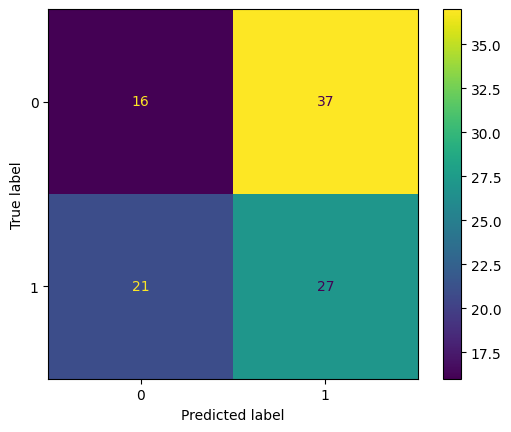

In [159]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

acc = accuracy_score(df_cv_selected_1['delta_y_cutoff_to_ds'], df_cv_selected_1['delta_y_cutoff_to_yhat'])
print('Accuracy: ', acc)

conf_mat = confusion_matrix(df_cv_selected_1['delta_y_cutoff_to_ds'], df_cv_selected_1['delta_y_cutoff_to_yhat'])
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()